In [16]:
import torch
from torch_geometric import nn, datasets
import pytorch_lightning as L
import torch.nn.functional as F
from torcheval import metrics
import matplotlib.pyplot as plt
import scienceplots
import os
from pathlib import Path

In [17]:
dataset = datasets.Planetoid("./datasets", "Cora")

In [18]:
print(f"Name: {dataset.name}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Number of edge features: {dataset.num_edge_features}")
print(f"Number of node features: {dataset.num_node_features:,}")

Name: Cora
Number of classes: 7
Number of edge features: 0
Number of node features: 1,433


In [19]:
class GCNModel(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        num_layers: int,
        dropout: float,
    ):
        super(GCNModel, self).__init__()
        self.gcn = torch.nn.ModuleList()
        for i in range(num_layers):
            self.gcn.append(
                nn.GraphConv(
                    in_channels if i == 0 else hidden_channels, hidden_channels
                )
        )
        self.act = torch.nn.ReLU()

        self.dropout = torch.nn.Dropout(dropout)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        self.softmax = torch.nn.Softmax(-1)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        h = x
        for layer in self.gcn:
            h = layer(h, edge_index)
            h = self.act(h)

        h = self.dropout(h)
        h = self.lin(h)
        h = self.softmax(h)

        return h

In [20]:
class GCNTrainer(L.LightningModule):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        num_layers: int,
        lr: float,
        dropout: float,
    ):
        super().__init__()
        self.model = GCNModel(
            in_channels,
            hidden_channels,
            out_channels,
            num_layers,
            dropout,
        )
        self.lr = lr
        self.criterion = torch.nn.CrossEntropyLoss()
        self.history = {
            "epochs": [],
            "loss" : [],
            "accuracy" : [],
            "val_loss" : [],
            "val_accuracy" : []
        }
        self.save_hyperparameters()

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):
        return self.model(x, edge_index)
    
    def _shared_eval_step(self, sample: torch.Tensor, mask: torch.Tensor):
        acc = metrics.MulticlassAccuracy()
        x, y, edge_index = sample.x, F.one_hot(sample.y), sample.edge_index
        pred = self.model(x, edge_index)
        loss = self.criterion(y[mask].float(), pred[mask])
        acc.update(sample.y[mask].float(), torch.argmax(pred[mask], -1))
        
        return loss, acc.compute()

    def training_step(self, sample: torch.Tensor):
        loss, acc = self._shared_eval_step(sample, sample.train_mask)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_acc", acc, prog_bar=True, logger=True)
        self.history["loss"].append(loss.item())
        self.history["accuracy"].append(acc.item())
        return loss

    def validation_step(self, sample: torch.Tensor):
        loss, acc = self._shared_eval_step(sample, sample.val_mask)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_acc", acc, prog_bar=True, logger=True)
        self.history["val_loss"].append(loss.item())
        self.history["val_accuracy"].append(acc.item())
        return loss

    def test_step(self, sample: torch.Tensor):
        loss, acc = self._shared_eval_step(sample, sample.test_mask)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_acc", acc, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [21]:
early_stop = L.callbacks.EarlyStopping(monitor="val_loss", mode="min", check_on_train_epoch_end=True, patience=10)
timer = L.callbacks.Timer()
model_checkpoint = L.callbacks.ModelCheckpoint("./lightning_logs")
callbacks = [early_stop, timer]

In [22]:
trainer_module = GCNTrainer(dataset.num_features, 32, dataset.num_classes, 2, 1e-3, 0.2)
trainer = L.Trainer(
    accelerator="gpu",
    precision="16-mixed",
    max_epochs=200,
    num_sanity_val_steps=0,
    val_check_interval=1,
    callbacks=callbacks,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


In [23]:
trainer.fit(trainer_module, dataset, dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | GCNModel         | 94.1 K
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
94.1 K    Trainable params
0         Non-trainable params
94.1 K    Total params
0.376     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 21.22it/s, v_num=44, train_loss=1.970, train_acc=0.357, val_loss=2.000, val_acc=0.204]

Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s, v_num=44, train_loss=1.180, train_acc=0.993, val_loss=1.470, val_acc=0.762]


In [24]:
print(f"Train time: {timer.time_elapsed('train'):.3f}s")
print(f"Validate time: {timer.time_elapsed('validate'):.3f}s")
print(f"Test time: {timer.time_elapsed('test'):.3f}s")

Train time: 13.406s
Validate time: 0.032s
Test time: 0.000s


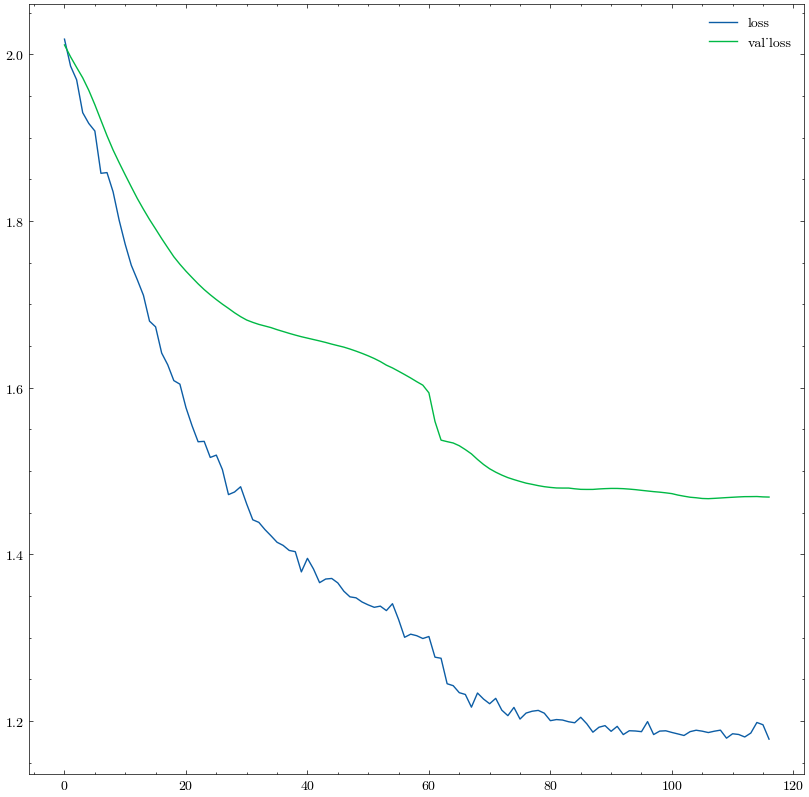

In [25]:
plt.style.use(["science", "no-latex"])
plt.figure(figsize=(10, 10))

plt.plot(range(trainer_module.current_epoch), trainer_module.history["loss"])
plt.plot(range(trainer_module.current_epoch), trainer_module.history["val_loss"])
plt.legend(["loss", "val_loss"])

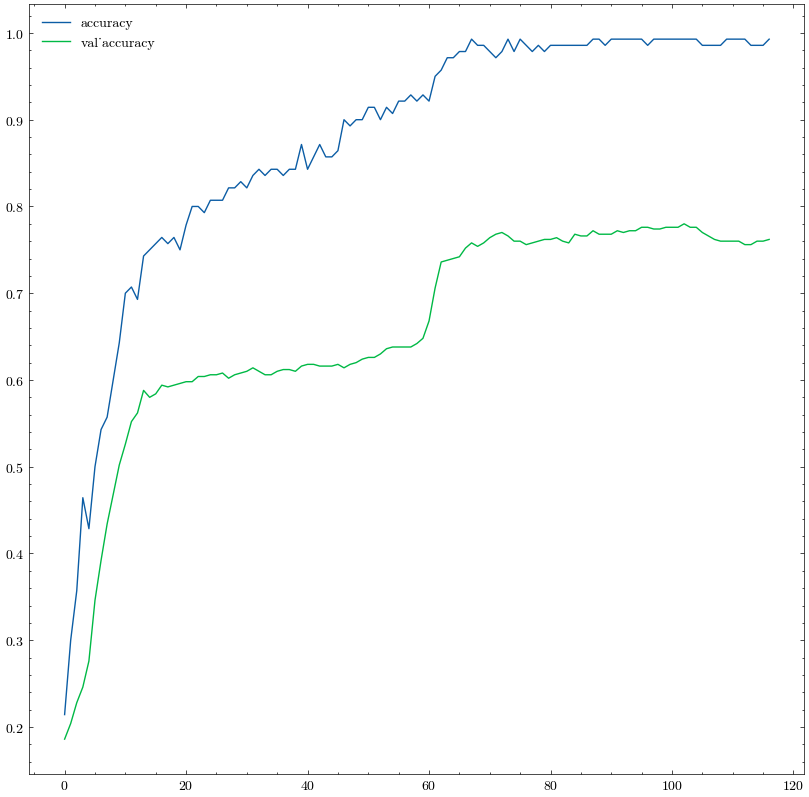

In [26]:
plt.style.use(["science", "no-latex"])
plt.figure(figsize=(10, 10))

plt.plot(range(trainer_module.current_epoch), trainer_module.history["accuracy"])
plt.plot(range(trainer_module.current_epoch), trainer_module.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])

In [27]:
paths = sorted(Path("./lightning_logs").iterdir(), key=os.path.getmtime, reverse=True)

ckpt_path = os.path.join(paths[0], "checkpoints")
ckpt_file = os.listdir(ckpt_path)[0]
ckpt_full_path = os.path.join(ckpt_path, ckpt_file)

In [28]:
ckpt_full_path

'lightning_logs\\version_44\\checkpoints\\epoch=116-step=117.ckpt'

In [29]:
model = GCNTrainer.load_from_checkpoint(ckpt_full_path)

In [30]:
trainer.test(model, dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7570000290870667     │
│         test_loss         │    1.4689189195632935     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.4689189195632935, 'test_acc': 0.7570000290870667}]